# Custom Federated Algorithms with the Federated Core API

In this tutorial, we introduce the Federated Core (FC), a set of lower-level
interfaces that can be used to implement custom types of federated algorithms,
and we show how one can implement a simplified version of federated training and
evaluation in terms of these lower-level interfaces.

The tutorial is designed to be self-contained, but it builds concepts
systematically in a bottom-up fashion, and somewhat in-depth. We encourage the
reader to first skim over
[Federated Learning for Image Classification](federated_learning_for_image_classification.md)
for a higher-level and more gentle introduction to the TensorFlow Federated
framework.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from tensorflow_federated import python as tff

tf.enable_resource_variables()

@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

'Hello, World!'

## Federated data

One of the key distinguishing features of TFF is that it allows you to compactly
express TensorFlow-based computations on *federated data*. We will be using the
term *federated data* in this tutorial to refer to a collection of data items
hosted across a group of devices in a distributed system.

One particularly important example of federated data that motivated the
development of TFF is on-device data created by an Android application and
hosted on a group of users' mobile phones.

Another example of federated data may be a collection of temperature readings in
an array of distributed sensors.

Federated data like those in the above examples are treated in TFF as
[first-class citizens](https://en.wikipedia.org/wiki/First-class_citizen), i.e.,
they may appear as parameters and results of functions, and they have types. To
reinforce this notion, we will henceforth refer in this tutorial to federated
data sets as *federated values*, or as *values of federated types*.

The important point to understand is that we are modeling the entire collection
of data items across all devices (e.g., the entire collection temperature
readings from all sensors in a distribuited array) as a single federated value.

For example, here's how one would define in TFF the type of *federated floats*
hosted by a group of client devices. A collection of temperature readings that
might materialize across an array of distributed sensors could be considered a
value of such federated type.

In [0]:
federated_float_on_clients = tff.FederatedType(tf.float32, tff.CLIENTS)

More generally, a federated type in TFF is defined by specifying the type `T` of
its *member constituents* - the items of data that reside on individual devices,
and the group `G` of devices on which federated values of this type are hosted
(plus a third, optional bit of information we'll mention shortly). We refer to
the group `G` of devices hosting a federated value as the value's *placement*.
Thus, `tff.CLIENTS` is an example of a placement.

In [3]:
str(federated_float_on_clients.member)

'float32'

In [4]:
str(federated_float_on_clients.placement)

'CLIENTS'

A federated type with member constituents `T` and placement `G` can be
represented compactly as `{T}@G`, as shown below.

In [5]:
str(federated_float_on_clients)

'{float32}@CLIENTS'

The curly braces `{}` in this concise notation serve as a reminder that the
member constituents (items of data on different devices) may differ, as you
would expect e.g., of temperature sensor readings, so the clients as a group are
jointly hosting a
[multi-set](https://en.wikipedia.org/wiki/Set_\(abstract_data_type\)#Multiset))
of `T`-typed items that together constitute the federated value.

Federated types in TFF come in two flavors: those where the member constituents
of a federated value may differ (as just seen above), and those where they are
known to be all equal. This is controlled by the third, optional `all_equal`
parameter in the `tff.FederatedType` constructor (defaulting to `False`).

In [6]:
federated_float_on_clients.all_equal

False

A federated type with a placement `G` in which all of the `T`-typed member
constituents are known to be equal can be compactly represented as `T@G` (as
opposed to `{T}@G`, that is, with the curly braces dropped to reflect the fact
that the multi-set of member constituents consists of a single item).

In [7]:
str(tff.FederatedType(tf.float32, tff.CLIENTS, all_equal=True))

'float32@CLIENTS'

One example of a federated value of such type that might arise in practical
scenarios is a hyperparameter (such as a learning rate, a clipping norm, etc.)
that's been broadcasted by a server to a group of devices that participate in
federated training.

Another example would be a set of parameters for a machine learning model that
had been pre-trained at the server, and that were subsequently broadcasted to a
group of client devices in order to be further individually personalized for
each user.

For example, suppose we have a pair of `float32` parameters `a` and `b` of a
simple one-dimensional linear regression model. We can construct the
(non-federated) type of such models for use in TFF as follows. The angle braces
`<>` in the printed type string are a compact TFF notation for named or unnamed
tuples.

In [8]:
simple_regression_model = (
    tff.NamedTupleType([('a', tf.float32), ('b', tf.float32)]))

str(simple_regression_model)

'<a=float32,b=float32>'

When such a model is broadcasted to the set of clients, the type of the
resulting federated value can be represented as shown below.

In [9]:
str(tff.FederatedType(simple_regression_model, tff.CLIENTS, all_equal=True))

'<a=float32,b=float32>@CLIENTS'

Per symmetry with *federated float* above, we will refer to such a type as a
*federated tuple*. More generally, we'll often use the term *federated XYZ* to
refer to a federated value in which member constituents are *XYZ*-like. Thus, we
will talk about things like *federated tuples*, *federated sequences*,
*federated models*, and so on.

Now, coming back to `float32@CLIENTS` - while it appears replicated across
multiple devices, it is actually a single `float32`, since all member are the
same. In general, you may think of any *all-equal* federated type, i.e., one of
the form `T@G`, as isomorphic to a non-federated type `T`, since in both cases,
there's actually only a single (albeit potentially replicated) item of type `T`.

Given the isomorphism between `T` and `T@G`, you may wonder what purpose, if
any, the latter types might serve. Read on.

## Placements

In the preceding section, we've introduced the concept of *placements* - groups
of systems participants that might be jointly hosting a federated value, and
we've demonstrated the use of `tff.CLIENTS` as an example specification of a
placement.

In order to explain why the notion of *placement* is so fundamental that we
needed to incorporate it into the TFF type system, we need to first say a few
words about some of the intended uses of TFF.

Although in this tutorial, you will only see TFF code being executed locally in
a simulated environment in the browser, our ultimate goal is for TFF to enable
writing code that you can deploy, unmodified, for execution on groups of
physical devices in a distributed system, each of which will need to receive a
separate set of instructions to execute locally, depending on the role it plays
in the system (an end-user device, a centralized coordinator, an intermediate
layer in a multi-tier architecture, etc.). It is important to be able to reason
about which subsets of devices execute what code, and where different portions
of the data might physically materialize.

This is especially important when dealing with, e.g., Android application data
on mobile devices. Since the data is private and can be sensitive, we need the
ability to statically verify that such data will never leave the device (and
prove facts about how the data is being processed). The placement specifications
are one of the mechanisms designed to support this.

TFF has been designed as a data-centric programming environment, and as such,
unlike some of the existing frameworks that focus on *operations* and where
those operations might *run*, TFF focuses on *data*, where that data
*materializes*, and how it's being *transformed*. Consequently, placement is
modeled as a property of data in TFF, rather than as a property of operations on
data.

Indeed, as you're about to see in the next section, some of the TFF operations
span across locations, and run "in the network", so to speak, rather than being
executed by a single machine or a group of machines. Representing the type of a
certain value as `T@G` or `{T}@G` (as opposed to just `T`) makes data placement
decisions explicit, and together with a static analysis of programs written in
TFF, it can serve as a foundation for providing formal privacy guarantees for
sensitive on-device data.

An important thing to note at this point, however, is that whereas we do
encourage users to be explicit about *groups* of participating devices that host
their data (the placements), the programmer will never deal with the identities
of the *individual* participants.

Within the body of TFF code, by design there's no way to e.g., enumerate the
devices that constitute the group represented by `tff.CLIENTS`, or to probe for
the existence of a specific device in the group. There's no concept of a device
or client identity anywhere in the Federated Core API, the underlying set of
architectural abstractions, or the core runtime infrastructure we provide to
support simulations. All the computation logic you write will be expressed as
operations on the entire client group.

Placements *are* designed to be a first-class citizen in TFF as well, and can
appear as parameters and results of a `placement` type, represented by
`tff.PlacementType` in the API. In the future, we do plan to eventually provide
a variety of operators that will allow you to transform or combine placements,
but this is outside the scope of this tutorial. For now, it suffices to think of
`placement` as an opaque primitive built-in type in TFF, similar to how `int`
and `bool` are opaque built-in types in Python, with `tff.CLIENTS` being a
constant literal of this type, not unlike `1` being a constant literal of type
`int`.

TFF provides two basic placement literals, `tff.CLIENTS` and `tff.SERVER`, to
make it easy to express the rich variety practical scenarios that are naturally
modeled as client-server architectures, with multiple *client* devices (mobile
phones, embedded devices, distributed databases, sensors, etc.) under the
control of a single centralized *server* coordinator. TFF is designed to also be
able to support custom placements, multiple client groups, multi-tiered and
other, more general distributed architectures, but discussing them is outside
the scope of this tutorial.

TFF doesn't prescribe what either the `tff.CLIENTS` or the `tff.SERVER` actually
represent. In particular, the server may be a single physical device (a member
of a singleton group), but it might just as well be a group of replicas in a
fault-tolerant cluster running state machine replication - we do not make any
special architectural assumptions. Rather, we use the `all_equal` bit mentioned
in the preceding section to express the fact that we're generally dealing with
only a single item of data at the server.

## Federated computations

TFF is designed as a strongly-typed functional programming environment that
supports modular development. The basic unit of composition in TFF is a
*federated computation* - a section of logic that may accept federated values at
intput and return federated values at output. Here's how you can define a
computation that calculates the average of the temperatures reported by the
sensor array from our previous example.

In [0]:
@tff.federated_computation(tff.FederatedType(tf.float32, tff.CLIENTS))
def get_average_temperature(sensor_readings):
  return tff.federated_average(sensor_readings)

TFF computations you will define are generally modeled as functions - with or
without parameters, but always with well-defined type signatures. Here's how you
can print the type signature of the computation `get_average_temperature` just
defined above.

In [11]:
str(get_average_temperature.type_signature)

'({float32}@CLIENTS -> float32@SERVER)'

The type signature tells us that the computation accepts a collection of
different sensor readings on client devices, and returns a single average on the
server, just as one would expect.

Functional type signatures are always represented compactly as `(T -> U)` for
some types `T` and `U` of inputs and outputs, respectively. The type of the
formal parameter `sensor_readings` is always specified as the argument to the
decorator. You don't need to specify the type of the result - it's determined
automatically.

Although TFF does offer limited forms of polymorphism, and we'll see examples of
it later, programmers are strongly encouraged to always be explicit about the
types of data they work with, as that makes understanding and debugging programs
easier. In some cases, expllicitly specifying types is a requirement (e.g.,
polymorphic computations are currently not directly executable).

In order to support development and debugging, TFF allows you to directly invoke
computations defined this way as Python functions, as shown below. Where the
computation expects a value of a federated type with the `all_equal` bit set to
`False`, you can feed it as a plain `list` in Python, and for federated types
with the `all_equal` bit set to `True`, you can just directly feed the (single)
member constituent. This is also how the results are reported back to you.

In [12]:
get_average_temperature([68.5, 70.3, 69.8])

69.533333

It is important to understand, however, that although the logic of TFF
computations can be expressed as ordinary functions in Python (you just need to
decorate them with `tff.federated_computation`), and you can directly invoke
them with Python arguments just like any other Python functions in this
notebook, behind the scenes, TFF computations are actually *not* Python.

What we mean by this is that TFF has an internal language that every section of
Python code decorated with `tff.federated_computation` is compiled into.

When the Python interpreter encounters a function decorated with
`tff.federated_computation`, it traces the statements in this function's body
once (at definition time), and then constructs a
[serialized representation](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/proto/v0/computation.proto)
of the computation's logic for future use - whether for execution, or to be
incorporated as a sub-component into another computation.

You can think of Python code that defines a federated computation similarly to
how you would think of Python code that builds a TensorFlow graph in a non-eager
context. The non-eager graph-building code in TensorFlow is Python, but the
TensorFlow graph constructed by this code is platform-independent and
serializable.

Likewise, TFF computations are defined in Python, but immediately compiled into
a portable and platform-independent serializable representation under the hood.
As a developer, you don't need to concern yourself with the details of this
representation, as you will never need to directly work with it, but you should
be aware of its existence, the fact that TFF computations are fundamentally
non-eager, and cannot capture arbitrary Python state. Python code contained in a
TFF computation's body is executed at definition time, when the body of the
Python function decorated with `tff.federated_computation` is traced before
getting serialized. It's not retraced again at invocation time (except when the
function is polymorphic; more on this later).

You may wonder why we've chosen to introduce a dedicated internal non-Python
representation. A part of the reason is that ultimately, TFF computations are
intended to be deployable to real physical environments, and hosted on groups of
mobile or embedded devices, where Python may simply not be available.

Another reason is that TFF computations express the global behavior of
distributed systems, as opposed to Python programs which express the local
behavior of individual participants. You can see it even in the simple example
above, with the special operator `tff.federated_average` that accepts data on
client devices, but deposits the results on the server. The
operator`tff.federated_average` cannot be easily modeled as an ordinary operator
in Python, since it doesn't execute locally - it represents a distributed
protocol that coordinates the behavior of multiple system participants. The
operator `tff.federated_average` is, in fact, a simple distributed system
embedded in the body of the computation. We will refer to such operators as
*federated operators*, to distinguish them from ordinary (local) operators in
Python.

Indeed, federated computations and their constituents *are* best understood as
models of distributed systems, and you can think of composing federated
computations as composing more complex distributed systems from simpler ones.
The TFF type system, and the kinds of operations supported in the TFF's
language, thus differ significantly from those in Python, necessitating the use
of a dedicated representation.

An important restriction to be aware of is that bodies of Python functions
decorated with `tff.federated_computation`must consist *only* of federated
operators, i.e., they cannot directly contain TensorFlow operations. TensorFlow
code must be confined to blocks of code decorated with a `tff.tf_computation`
discussed in the following section.

## TensorFlow logic

TFF is designed for use with TensorFlow, and although it introduces things like
federated types, and operators such as `tff.federated_average`, the bulk of the
code you will write in TFF is ordinary TensorFlow. In order to use such code
with TFF, as noted above, it just needs to be decorated with
`tff.tf_computation`.

For example, here's how we could implement a function that takes a number and
adds `0.5` to it.

In [0]:
@tff.tf_computation(tf.float32)
def add_half(x):
  return tf.add(x, 0.5)

A computation `add_half` defined this way can be just just like any other TFF
computation. In particular, it has a TFF type signature.

In [14]:
str(add_half.type_signature)

'(float32 -> float32)'

You can also now use such computation as a building block in other places. For
example, here's how you can use the `tff.federated_map` operator to apply
`add_half` pointwise to all member constituents of a federated float on client
devices.

In [0]:
@tff.federated_computation(tff.FederatedType(tf.float32, tff.CLIENTS))
def add_half_on_clients(x):
  return tff.federated_map(add_half, x)

In [16]:
str(add_half_on_clients.type_signature)

'({float32}@CLIENTS -> {float32}@CLIENTS)'

In [17]:
add_half_on_clients([1.0, 3.0, 2.0])

[1.5, 3.5, 2.5]

Keep in mind that what we said in the preceding section about TFF computations
getting serialized at the definition time remains true as well. The only
difference between Python methods decorated with `tff.federated_computation` and
those decorated with `tff.tf_computation` is that the latter are expected to
contain TensorFlow code, and their bodies are serialized as TensorFlow graphs
(whereas the former are not allowed to contain TensorFlow code directly embedded
in them). Under the hood, each method decorated with `tff.tf_computation`
executes against its own instance of an empty `tf.Graph`. You can welcome to use
eager TensorFlow, AutoGraph, TensorFlow 2.0 constructs, etc., so long as the
logic of your computation can get correctly captured as a part of this local
graph instance, and correctly serialized unpon existing the wrapped method's
body.

In particular, `tff.tf_computation` allows you to work with `tf.data.Dataset`s,
including abstractly-defined data sets that you can declare as a formal
parameter. The support for this is still somewhat limited, but functional in
simple scenarios such as those used in this tutorial.

For example, suppose that in our temperature sensor example, each sensor holds
not just one temperature reading, but multiple. Here's how you can define a TFF
computation in TensorFlow that calculates the average of temperatures in a
single local data set using the `tf.data.Dataset.reduce` operator.

In [0]:
@tff.tf_computation(tff.SequenceType(tf.float32))
def get_local_temperature_average(local_temperatures):
  sum_and_count = (
      local_temperatures.reduce((0.0, 0), lambda x, y: (x[0] + y, x[1] + 1)))
  return sum_and_count[0] / tf.to_float(sum_and_count[1])

The type specification `tff.SequenceType(tf.float32)` defines an abstract
sequence of float elements in TFF. Sequences can contain either tensors, or
complex nested structures (we'll see examples of those later). The concise
representation of a sequence of `T`-typed items is `T*`.

In [19]:
str(tff.SequenceType(tf.float32))

'float32*'

In [20]:
str(get_local_temperature_average.type_signature)

'(float32* -> float32)'

In the body of a method decorated with `tff.tf_computation`, formal parameters
of a TFF sequence type are represented simply as instances of `tf.data.Dataset`.
You can easily verify this as follows.

In [21]:
@tff.tf_computation(tff.SequenceType(tf.float32))
def _(x):
  print (isinstance(x, tf.data.Dataset))
  return 0  # Computations must return something, so just return a dummy value.

True


Keep in mind that these data sets are constructed from placeholders. They don't
contain any elements, since they represent abstract parameters, to be bound to
concrete data when used in a concrete context. This introduces some limitations,
but we won't need to worry about it in this tutorial.

When locally executing a computation that accepts a sequence in a simulation
mode, such as in this tutorial, you can feed the sequence as Python list, as
below (as well as in other ways, e.g., as a `tf.data.Dataset` in eager mode, but
for now, we'll keep it simple).

In [22]:
get_local_temperature_average([68.5, 70.3, 69.8])

69.533333

Now, let's try again to use our TensorFlow computation in a federated setting.
Suppose we have a group of sensors that each have a local sequence of
temperature readings. We can compute the global temperature average by averaging
the sensors' local averages as follows.

In [0]:
@tff.federated_computation(
    tff.FederatedType(tff.SequenceType(tf.float32), tff.CLIENTS))
def get_global_temperature_average(sensor_readings):
  return tff.federated_average(
      tff.federated_map(get_local_temperature_average, sensor_readings))

Note that this isn't a simple average across all local temperature readings from
all clients, as that would require weighing contributions from different clients
by the number of readings they locally maintain. We leave it as an exercise for
the reader to update the above code; the `tff.federated_average` operator
accepts the weight as an optional second argument (expected to be a federated
float).

Also note that the input to `get_global_temperature_average` now becomes a
*federated int sequence*. Federated sequences is how we will typically represent
on-device data in federated learning, with sequence elements typically
representing data batches (you will see examples of this shortly).

In [24]:
str(get_global_temperature_average.type_signature)

'({float32*}@CLIENTS -> float32@SERVER)'

Here's how we can locally execute the computation on a sample of data in Python.
Notice that the way we supply the input is now as a `list` of `list`s. The outer
list iterates over the devices in the group represented by `tff.CLIENTS`, and
the inner ones iterate over elements in each device's local sequence.

In [25]:
get_global_temperature_average([[68.0, 70.0], [71.0], [68.0, 72.0, 70.0]])

70.0

## Federated averaging

Now, let's use what we've learned so far to implement a simple version of
federated averaging. For symmetry with
[Federated Learning for Image Classification](federated_learning_for_image_classification.md),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.

### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit.

First, let's load the standard MNIST data from the TensorFlow website.

In [0]:
#@test {"output": "ignore"}
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [27]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

The data comes as Numpy arrays, one with images and another with digits, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `X` and `Y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range.

In [0]:
BATCH_SIZE = 100

def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, len(all_samples), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                      dtype=np.float32),
        'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)})
  return output_sequence

federated_train_data = [get_data_for_digit(mnist_train, d) for d in xrange(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in xrange(10)]

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

In [29]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Just to be sure, let's also look at the image corresponding to the last element of that batch.

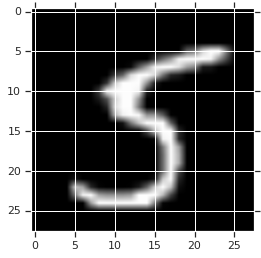

In [30]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')

### Defining a loss function

Now that we have the data, let's define a loss function that we can use for
training. First, let's define the type of input as a TFF named tuple. Since the
size of data batches may vary, we set the batch dimension to `None` to indicate
that it the size of this dimension is unknown.

In [31]:
BATCH_TYPE = tff.NamedTupleType([
    ('x', tff.TensorType(tf.float32, [None, 784])),
    ('y', tff.TensorType(tf.int32, [None]))])

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

Let's also define the model parameters as a TFF named tuple.

In [32]:
MODEL_TYPE = tff.NamedTupleType([
    ('weights', tff.TensorType(tf.float32, [784, 10])),
    ('bias', tff.TensorType(tf.float32, [10]))])

str(MODEL_TYPE)

'<weights=float32[784,10],bias=float32[10]>'

With those definitions in place, now we can define loss for a given model, over
a single batch.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  predicted_y = tf.nn.softmax(tf.matmul(batch.x, model.weights) + model.bias)
  return -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(batch.y, 10) * tf.log(predicted_y), reduction_indices=[1]))

As expected, computation `batch_loss` returns `float32` loss given the model and
a single data batch.

In [34]:
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

As a sanity check, let's construct an initial model filled with zeros and
compute the loss over the batch of data we visualized above.

In [35]:
initial_model = {
    'weights': np.zeros([784, 10], dtype=np.float32),
    'bias': np.zeros([10], dtype=np.float32)
}

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

Now, let's define a computation that uses this loss function to perform a single
step of gradient descent. Note how in defining this function, we use
`batch_loss` a component. You can always invoke a computation constructed with
`tff.tf_computation` inside the body of another computation.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_train(initial_model, batch):
  # Define a group of model variables and set them to `initial_model`.
  model_vars = tff.utils.get_variables('v', MODEL_TYPE)
  init_model = tff.utils.assign(model_vars, initial_model)

  # Perform one step of gradient descent using loss from `batch_loss`.
  optimizer = tf.train.GradientDescentOptimizer(0.01)
  with tf.control_dependencies([init_model]):
    train_model = optimizer.minimize(batch_loss(model_vars, batch))

  # Return the model vars after performing this gradient descent step.
  with tf.control_dependencies([train_model]):
    return tff.utils.identity(model_vars)

In [37]:
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> <weights=float32[784,10],bias=float32[10]>)'

Let's apply this function a few times to the initial model to see whether the
loss decreases.

In [0]:
model = initial_model
losses = []
for _ in xrange(10):
  model = batch_train(model, sample_batch)
  losses.append(batch_loss(model, sample_batch))

In [39]:
#@test {"output": "ignore"}
losses

[1.9215734,
 1.5863497,
 1.305056,
 1.0791202,
 0.90296584,
 0.76719612,
 0.66217637,
 0.57991415,
 0.5144133,
 0.46136084]

Now, since `batch_train` appears to work, let's write a similar training
function `local_train` that consumes the entire sequence of all batches from one
user instead of just a single batch. The new computation will need to now
consume `tff.SequenceType(BATCH_TYPE)` instead of `BATCH_TYPE`.

One way to process this sequence could be, to use `tf.data.Dataset.reduce`
similarly to how we've used it earlier. But, we can also use a federated
operator `tff.sequence_reduce` to make it more concise.

We can also use `batch_train` as a component in it, similarly to how we've used
`batch_loss` as a component in `batch_train`.

In [0]:
@tff.federated_computation(MODEL_TYPE, tff.SequenceType(BATCH_TYPE))
def local_train(initial_model, all_batches):
  return tff.sequence_reduce(all_batches, initial_model, batch_train)

In [41]:
str(local_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

Let's try the newly defined local training function on the entire sequence of
data from the same user who contributed the sample batch (digit `5`).

In [0]:
trained_model = local_train(initial_model, federated_train_data[5])

(to be continued)